<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%ED%86%B5%ED%95%A9%ED%85%8C%EC%9D%B4%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘 시작

## 라이브러리 설치

In [1]:
!pip install finance-datareader
!pip install pykrx
!pip install pymysql
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

     |████████████████████████████████| 70 kB 3.6 MB/s 
     |████████████████████████████████| 60 kB 6.4 MB/s 
     |████████████████████████████████| 251 kB 33.1 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 19.4 MB 53.8 MB/s 
     |████████████████████████████████| 448 kB 42.8 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## 패키지 & 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

In [4]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min())) + org_x_np.min()

## 통합테이블 생성

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# total_table = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/total_table.csv') # 기존 테이블

In [7]:
# 구성
dic = {'code' : [],
       'date' : [],
       'lstm' : [],
       'arima' : [],
       'fbprophet' : [],
       'RL' : [],
    #    'mail_news' : [],
    #    'mail_news_nsi' : [],
    #    'asia_news' : [],
    #    'asia_news_nsi': [],
    #    'youtube_sam' : [],
    #    'youtube_su' : [],
    #    'youtube_han' : [],
       'close' : []}

total_table = pd.DataFrame(dic)

In [8]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'close'], dtype='object')

In [9]:
total_table

,code,date,lstm,arima,fbprophet,RL,close


## LSTM 예측결과

### 사용 데이터 로드 및 전처리

In [10]:
# start_date = (datetime.datetime.now() - datetime.timedelta(40)).strftime("%Y%m%d")
end_date = datetime.datetime.now().strftime("%Y%m%d")
lstm = money_sur('005930', '2018', end_date)

In [11]:
lstm = lstm.set_index('Date')

In [12]:
lstm.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177,1156530,16.15,2.21,157967,1.12,28500
2018-01-03,52540,52560,51420,51620,200270,0.011760,1156530,16.34,2.23,157967,1.10,28500
2018-01-04,52120,52180,50640,51080,233909,-0.010461,1156530,16.17,2.21,157967,1.12,28500
2018-01-05,51300,52120,51200,52120,189623,0.020360,1156530,16.50,2.25,157967,1.09,28500
2018-01-08,52400,52520,51500,52020,167673,-0.001919,1156530,16.47,2.25,157967,1.10,28500


In [13]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
lstm_sc = sc.fit_transform(lstm)

In [14]:
scale_cols = lstm.columns
lstm_sc_df = pd.DataFrame(lstm_sc, columns=[scale_cols], index=lstm.index)

In [15]:
lstm_sc_df.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,0.568992,0.530992,0.567374,0.253408,0.001877,0.385888,0.818782,0.440444,0.832,0.521739,0.012945,0.663866
2018-01-03,0.581838,0.542975,0.574525,0.264613,0.002218,0.448663,0.818782,0.448889,0.848,0.521739,0.006472,0.663866
2018-01-04,0.577187,0.539050,0.565810,0.254528,0.002590,0.316851,0.818782,0.441333,0.832,0.521739,0.012945,0.663866
2018-01-05,0.568106,0.538430,0.572067,0.273950,0.002100,0.499677,0.818782,0.456000,0.864,0.521739,0.003236,0.663866
2018-01-08,0.580288,0.542562,0.575419,0.272082,0.001857,0.367523,0.818782,0.454667,0.864,0.521739,0.006472,0.663866


In [16]:
for i in scale_cols:
  for s in range(1, 11):  
    lstm_sc_df[(i+'shift_{}'.format(s),)] = lstm_sc_df[(i,)].shift(s)

In [17]:
lstm_sc_df.dropna()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.539978,0.517975,0.543240,0.234360,0.004516,0.557323,0.818782,0.426222,0.792,0.521739,0.019417,0.663866,0.540421,0.534219,0.533776,0.559247,0.569878,0.580288,0.568106,0.577187,0.581838,0.568992,0.505992,0.500826,0.508884,0.521901,0.534298,0.542562,0.538430,0.539050,0.542975,0.530992,0.535419,0.522458,0.536536,0.543464,0.558436,0.575419,0.572067,0.565810,...,0.744,0.728,0.736,0.752,0.808,0.864,0.864,0.832,0.848,0.832,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.029126,0.032362,0.032362,0.029126,0.016181,0.006472,0.003236,0.012945,0.006472,0.012945,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-17,0.553931,0.516736,0.548156,0.227264,0.002448,0.333823,0.818782,0.420889,0.784,0.521739,0.022654,0.663866,0.539978,0.540421,0.534219,0.533776,0.559247,0.569878,0.580288,0.568106,0.577187,0.581838,0.517975,0.505992,0.500826,0.508884,0.521901,0.534298,0.542562,0.538430,0.539050,0.542975,0.543240,0.535419,0.522458,0.536536,0.543464,0.558436,0.575419,0.572067,...,0.792,0.744,0.728,0.736,0.752,0.808,0.864,0.864,0.832,0.848,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.019417,0.029126,0.032362,0.032362,0.029126,0.016181,0.006472,0.003236,0.012945,0.006472,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-18,0.553931,0.523140,0.556648,0.232493,0.003289,0.412377,0.818782,0.424444,0.792,0.521739,0.019417,0.663866,0.553931,0.539978,0.540421,0.534219,0.533776,0.559247,0.569878,0.580288,0.568106,0.577187,0.516736,0.517975,0.505992,0.500826,0.508884,0.521901,0.534298,0.542562,0.538430,0.539050,0.548156,0.543240,0.535419,0.522458,0.536536,0.543464,0.558436,0.575419,...,0.784,0.792,0.744,0.728,0.736,0.752,0.808,0.864,0.864,0.832,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.022654,0.019417,0.029126,0.032362,0.032362,0.029126,0.016181,0.006472,0.003236,0.012945,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-19,0.557918,0.520455,0.547933,0.221662,0.002042,0.309957,0.818782,0.416444,0.768,0.521739,0.025890,0.663866,0.553931,0.553931,0.539978,0.540421,0.534219,0.533776,0.559247,0.569878,0.580288,0.568106,0.523140,0.516736,0.517975,0.505992,0.500826,0.508884,0.521901,0.534298,0.542562,0.538430,0.556648,0.548156,0.543240,0.535419,0.522458,0.536536,0.543464,0.558436,...,0.792,0.784,0.792,0.744,0.728,0.736,0.752,0.808,0.864,0.864,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.019417,0.022654,0.019417,0.029126,0.032362,0.032362,0.029126,0.016181,0.006472,0.003236,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-22,0.538649,0.502893,0.535866,0.201494,0.002773,0.249011,0.818782,0.401333,0.736,0.521739,0.032362,0.663866,0.557918,0.553931,0.553931,0.539978,0.540421,0.534219,0.533776,0.559247,0.569878,0.580288,0.520455,0.523140,0.516736,0.517975,0.505992,0.500826,0.508884,

In [18]:
X_test = lstm_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = lstm_sc_df.dropna()[['Close']]

X_test= X_test.values
y_test = y_test.values

In [19]:
X_test

array([[0.54042082, 0.53421927, 0.5337763 , ..., 0.66386555, 0.66386555,
        0.66386555],
       [0.53997785, 0.54042082, 0.53421927, ..., 0.66386555, 0.66386555,
        0.66386555],
       [0.55393134, 0.53997785, 0.54042082, ..., 0.66386555, 0.66386555,
        0.66386555],
       ...,
       [0.82834994, 0.86046512, 0.85603544, ..., 0.05147659, 0.05147659,
        0.05147659],
       [0.82281285, 0.82834994, 0.86046512, ..., 0.05147659, 0.05147659,
        0.05147659],
       [0.81838317, 0.82281285, 0.82834994, ..., 0.05147659, 0.05147659,
        0.05147659]])

In [20]:
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

### 모델 로드

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dense(32, activation = 'relu'))
model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'tanh'))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))



lstm_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/LSTM/'
samsung_lstm = 'lstm_samsung.h5'

model.load_weights(lstm_path+samsung_lstm)

### 모델 결과

In [22]:
pred = model.predict(X_test_t)

In [23]:
pred.shape, y_test.shape

((915, 1), (915, 1))

In [24]:
pred_act = reverse_min_max_scaling(lstm['Close'], pred)

In [25]:
total_table['date'] = lstm.index[10:]
total_table['lstm'] = pred_act[:]
total_table['close'] = lstm.Close[10:].values.reshape(-1,1)
total_table['code'] = '005930'
total_table['change'] = lstm.Change[10:].values.reshape(-1,1)

In [26]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005930,2018-01-16,49949.609375,NaN,NaN,NaN,50000,0.030078
1,005930,2018-01-17,49448.875000,NaN,NaN,NaN,49620,-0.007600
2,005930,2018-01-18,49286.160156,NaN,NaN,NaN,49900,0.005643
3,005930,2018-01-19,49762.640625,NaN,NaN,NaN,49320,-0.011623
4,005930,2018-01-22,49158.433594,NaN,NaN,NaN,48240,-0.021898
...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,NaN,NaN,NaN,76300,-0.018018
911,005930,2021-09-29,73761.250000,NaN,NaN,NaN,74100,-0.028834
912,005930,2021-09-30,73149.437500,NaN,NaN,NaN,74100,0.000000
913,005930,2021-10-01,72290.070312,NaN,NaN,NaN,73200,-0.012146


## arima 예측결과

In [27]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('005930', '2000', end_date)

In [28]:
df = samsung_df[['Date','Close']]
df.columns = ['Date', 'Price']

In [30]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# 학습, 테스트 데이터 분리
for ru in range(-len(total_table),0):
    rus = ru+1
    train = df[:ru]
    test = df[ru:]

    if ru >= -10:
      model = ARIMA(train.Price.values, order = (2,1,2))
      model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
    else:
      model = ARIMA(train.Price.values, order = (2,2,0))
      model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
    

    fore = model_fit.forecast(steps=1) # 오늘 예측

    # 오늘 예측 데이터
    pred_arima_y = fore[0].tolist()

    # 실제 오늘 데이터 
    test_y = test.Price.values

    # # 신뢰구간
    # # 예측 데이터 최소값
    # pred_y_lower = []
    # # 예측 데이터 최대값
    # pred_y_upper = []

    # for lower_upper in fore[2]:
    #     lower = lower_upper[0]
    #     upper = lower_upper[1]
    #     pred_y_lower.append(lower)
    #     pred_y_upper.append(upper)
    if rus == 0:
        total_table['arima'].iloc[ru:] = pred_arima_y
    else:
        total_table['arima'].iloc[ru:rus] = pred_arima_y

print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5369
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -41047.643
Method:                       css-mle   S.D. of innovations            505.914
Date:                Tue, 05 Oct 2021   AIC                          82105.286
Time:                        05:58:11   BIC                          82138.228
Sample:                             1   HQIC                         82116.790
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y     -0.5901      0.251     -2.353      0.019      -1.082      -0.099
ar.L2.D.y     -0.6023      0.202     -2.975      0.003      -0.999      -0.205
ma.L1.D.y      0.6293      0.252      2.498      0.0

In [31]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005930,2018-01-16,49949.609375,48481.218093,NaN,NaN,50000,0.030078
1,005930,2018-01-17,49448.875000,50694.848123,NaN,NaN,49620,-0.007600
2,005930,2018-01-18,49286.160156,49940.263145,NaN,NaN,49900,0.005643
3,005930,2018-01-19,49762.640625,50390.993594,NaN,NaN,49320,-0.011623
4,005930,2018-01-22,49158.433594,49024.496849,NaN,NaN,48240,-0.021898
...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,NaN,NaN,76300,-0.018018
911,005930,2021-09-29,73761.250000,76250.904904,NaN,NaN,74100,-0.028834
912,005930,2021-09-30,73149.437500,73992.376613,NaN,NaN,74100,0.000000
913,005930,2021-10-01,72290.070312,74002.304636,NaN,NaN,73200,-0.012146


## fbprophet 예측

In [32]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('005930', start = '20180101', end = end_date)
df1 = samsung_df[['Date','Close']]
df1.columns = ['ds', 'y']

from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.6)

prophet.fit(df1)

# 10일단위로 예측값을 가져옴
future_data = prophet.make_future_dataframe(periods = 10, freq = 'd')
forecast_data = prophet.predict(future_data)

In [33]:
list(total_table.date.values)

[numpy.datetime64('2018-01-16T00:00:00.000000000'),
 numpy.datetime64('2018-01-17T00:00:00.000000000'),
 numpy.datetime64('2018-01-18T00:00:00.000000000'),
 numpy.datetime64('2018-01-19T00:00:00.000000000'),
 numpy.datetime64('2018-01-22T00:00:00.000000000'),
 numpy.datetime64('2018-01-23T00:00:00.000000000'),
 numpy.datetime64('2018-01-24T00:00:00.000000000'),
 numpy.datetime64('2018-01-25T00:00:00.000000000'),
 numpy.datetime64('2018-01-26T00:00:00.000000000'),
 numpy.datetime64('2018-01-29T00:00:00.000000000'),
 numpy.datetime64('2018-01-30T00:00:00.000000000'),
 numpy.datetime64('2018-01-31T00:00:00.000000000'),
 numpy.datetime64('2018-02-01T00:00:00.000000000'),
 numpy.datetime64('2018-02-02T00:00:00.000000000'),
 numpy.datetime64('2018-02-05T00:00:00.000000000'),
 numpy.datetime64('2018-02-06T00:00:00.000000000'),
 numpy.datetime64('2018-02-07T00:00:00.000000000'),
 numpy.datetime64('2018-02-08T00:00:00.000000000'),
 numpy.datetime64('2018-02-09T00:00:00.000000000'),
 numpy.datet

In [34]:
total_table['fbprophet'] = forecast_data[forecast_data['ds'].isin(list(total_table.date.values))]['yhat'].values

In [35]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005930,2018-01-16,49949.609375,48481.218093,50313.475602,NaN,50000,0.030078
1,005930,2018-01-17,49448.875000,50694.848123,50192.064834,NaN,49620,-0.007600
2,005930,2018-01-18,49286.160156,49940.263145,50106.696658,NaN,49900,0.005643
3,005930,2018-01-19,49762.640625,50390.993594,49988.612655,NaN,49320,-0.011623
4,005930,2018-01-22,49158.433594,49024.496849,49668.398542,NaN,48240,-0.021898
...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,75529.274498,NaN,76300,-0.018018
911,005930,2021-09-29,73761.250000,76250.904904,75262.323033,NaN,74100,-0.028834
912,005930,2021-09-30,73149.437500,73992.376613,75062.875020,NaN,74100,0.000000
913,005930,2021-10-01,72290.070312,74002.304636,74827.026205,NaN,73200,-0.012146


In [36]:
# total_table.to_csv('./total_table.csv', index =False)

## RL 결과

### 데이터 로딩 및 함수 로딩

In [37]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.8):
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')
    date_split = data.index[int(train_ratio*len(data))] 

    return data[:date_split], data[date_split:], date_split


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

In [38]:
(train, test, date_split) = dataset_loaderKR('005930', start = '2000', end = end_date)

### 모델 로딩 및 결과

In [39]:
rl_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/RL/삼성_결과/'
samsung_rl = 'samsung_rl_재무.h5'

In [40]:
# 모델 로딩
model = torch.load(rl_path+samsung_rl)

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print("결과")
print( "손익결과 $%.2f" % round(test_profits,2) )
# 0: Idle
# 1: 매수
# 2: 매도


           Date   Open   High    Low  Close  ...   PBR     EPS   DIV    DPS  Action
4296 2017-05-22  45040  45380  44760  45100  ...  1.95  157967  1.26  28500       1
4297 2017-05-23  45400  45580  44900  44920  ...  1.94  157967  1.27  28500       2
4298 2017-05-24  44860  45300  44800  44880  ...  1.94  157967  1.27  28500       2
4299 2017-05-25  45160  45680  44800  45680  ...  1.97  157967  1.25  28500       0
4300 2017-05-26  45600  46460  45540  46080  ...  1.99  157967  1.24  28500       2
...         ...    ...    ...    ...    ...  ...   ...     ...   ...    ...     ...
5366 2021-09-28  77700  77800  76200  76300  ...  1.94    3841  3.92   2994       0
5367 2021-09-29  74800  75300  73800  74100  ...  1.88    3841  4.04   2994       1
5368 2021-09-30  74300  74800  73700  74100  ...  1.88    3841  4.04   2994       2
5369 2021-10-01  73900  74000  72900  73200  ...  1.86    3841  4.09   2994       2
5370 2021-10-05  73000  73000  71400  71800  ...  1.82    3841  4.17   2994

In [41]:
test['Action'] = np.where(test['Action'] == 1,1,
                          np.where(test['Action'] == 2,-1,0))

In [42]:
test['Action'][-10:]

5361    0
5362   -1
5363   -1
5364   -1
5365   -1
5366    0
5367    1
5368   -1
5369   -1
5370    0
Name: Action, dtype: int64

In [43]:
total_table['RL'] = test[test['Date'].isin(list(total_table.date.values))]['Action'].values

In [44]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005930,2018-01-16,49949.609375,48481.218093,50313.475602,0,50000,0.030078
1,005930,2018-01-17,49448.875000,50694.848123,50192.064834,0,49620,-0.007600
2,005930,2018-01-18,49286.160156,49940.263145,50106.696658,0,49900,0.005643
3,005930,2018-01-19,49762.640625,50390.993594,49988.612655,-1,49320,-0.011623
4,005930,2018-01-22,49158.433594,49024.496849,49668.398542,-1,48240,-0.021898
...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,75529.274498,0,76300,-0.018018
911,005930,2021-09-29,73761.250000,76250.904904,75262.323033,1,74100,-0.028834
912,005930,2021-09-30,73149.437500,73992.376613,75062.875020,-1,74100,0.000000
913,005930,2021-10-01,72290.070312,74002.304636,74827.026205,-1,73200,-0.012146


## News 긍부정 결과
- '매일경제', '아시아경제'

In [45]:
# corp_list = ['samsung', 'hyundai', 'lg', 'sk', 'celltrion'] 참고용
stock_num_list = ['005930', '005380', '051910', '000660', '068270']
news = ['maeil_news_craw', 'asia_news_craw']
start = (datetime.datetime.now() - datetime.timedelta(20)).strftime("%Y-%m-%d").replace('-','')
end = datetime.datetime.now().strftime("%Y-%m-%d").replace('-', '')

In [46]:
# news_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/Final Data/1. samsung_score.csv') # 연습용

### 관련 함수 및 패키지 로드

In [47]:
import pymysql
import sys
import re

In [48]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

In [49]:
def news_db(news, stock):
    db = pymysql.connect(
            user='root', 
            passwd='1234', 
            host='3.35.70.166', 
            db='proj', 
            charset = 'utf8'
        )

    cursor = db.cursor(pymysql.cursors.DictCursor)
    news1 = news + '_news_craw'

    sql = "select * from {0}_{1} where length(date)=10".format(news1, stock)
    cursor.execute(sql)
    result = cursor.fetchall()

    # DataFrame으로 변경
    df = pd.DataFrame(result)

    db.close()

    df.rename(columns={'date': 'datetime'}, inplace=True)

    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
    df['date'] = pd.to_datetime(df['date'])

    # 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
    df = df.dropna()

    # 시간순으로 정렬
    df.sort_values('datetime', inplace=True)
    df.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)

    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
    stopwords = list(pd.read_csv(url, header=None)[0])

    # Stop Words List에 각 매체명 추가
    except_media_list = ['매일경제', '매일', '경제', 'maeil', 'MK', 'mk',
                         '아시아경제', '아시아', 'Asia', 'ASIA', 'asia',
                         '삼프로TV', '삼프로', 'TV',
                         '슈카월드', '슈카', '월드'
                         '한국경제TV', '한국']
    for word in except_media_list:
        stopwords.append(word)
    
    #### 2. Preprocessing
    '''감성 어휘 사전 : negative / positive
       뉴스 데이터 : samsung / hyundai / lg / sk
       주식 데이터 : stock_samsung / stock_hyundai / stock_lg / stock_sk
       공휴일 데이터 : holidays'''
    
    
    ### 1) 뉴스 데이터 날짜 조정
    
    ## 1-1)업로드 시각 컬럼 추가
    df['time'] = df['datetime'].str[-2:]
    
    ## 1-2) 전일 15시 ~ 금일 15시로 날짜 조정
    after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

    for j in range(len(df['time'])):
        if df['time'][j] in after_market:
            df['date'][j] += datetime.timedelta(1)
        else:
            pass
    
    ## 1-3) 텍스트 전처리
    # \n, \t, \r 제거
    df['text'] = df['text'].str.replace('[\n|\t|\r]', '')
    df['text'] = df['text'].str.replace('\[|\]', '')
    df['text'] = df['text'].str.replace('\<.*\>', '')
    df['text'] = df['text'].str.replace('\\', '')
    df['text'] = df['text'].str.replace('이미지', '')


    ### 2) 주말 및 공휴일 제외
    
    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df[df['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df[df['date'].isin(market_closed_list)]['date'].index:
            df['date'][hoil] += datetime.timedelta(1)
    
    ### 3) Tokenization 컬럼 추가
    
    df['Tokenization'] = 0
    rows = df.shape[0]
    for row in range(rows):
        hangeul = re.compile('[^ ㄱ-ㅣ 가-힣]')                                    # 정규 표현식 → 한글 추출 규칙 : 띄어쓰기(1개)를 포함한 한글
        result = hangeul.sub('', df['text'][row])   # 위에 설정한 hangeul 규칙을 text에 적용
        okt = Okt()                                                               # 형태소 추출
        nouns = okt.nouns(df['text'][row])
        nouns = [x for x in nouns if len(x) > 1]                                  # 한 글자 키워드 제거
        nouns = [x for x in nouns if x not in stopwords]                          # 불용어 제거
        
        corpus = " ".join(nouns)                                                  # List를 String으로 변환
        df['Tokenization'][row] = corpus


    # 점수 산출

    df['Positive_Score'] = 0
    df['Negative_Score'] = 0
    df['Ratio'] = 0.1
    df['Pred'] = 0
    df['NSI'] = 0.1
    
    for score in range(len(df)):
        pos_score = 0 ; neg_score = 0
        
        for token in range(len(df['Tokenization'][score].split())):
            if df['Tokenization'][score].split()[token] in positive:
                pos_score += 1
            elif df['Tokenization'][score].split()[token] in negative:
                neg_score += 1
            else:
                pass
        
        df['Positive_Score'][score] = pos_score
        df['Negative_Score'][score] = neg_score
        
        # 긍정과 부정의 비율
        if (pos_score==0) and (neg_score==0):
            df['Ratio'][score] = 0.5   # 둘 다 0일 경우에는 긍정으로 가정
        else:
            df['Ratio'][score] = pos_score / (pos_score + neg_score)
        
        # 예측 결과
        if df['Ratio'][score]>=0.5:
            df['Pred'][score] = 1
        else:
            df['Pred'][score] = -1
        
        # 뉴스심리지수(NSI) 계산
        if (pos_score==0) and (neg_score==0):
            df['NSI'][score] = 101
        else:
            df['NSI'][score] = (pos_score - neg_score) / (pos_score + neg_score) * 100 + 100
    
    return df

### 매일경제

In [50]:
# mail_df = news_df[(news_df['news'] == '매일경제') & (news_df['st_cd'] == 5930)]

In [51]:
mail_df = news_db('maeil', '005930')

In [52]:
mail_df.head()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
0,삼성전자,005930,매일경제,2018010100,"동원산업·휠라코리아 ""생큐 트럼프""",http://news.mk.co.kr/newsRead.php?year=2018&no=30,■ 2018 美법인세인하 수혜株 올해 1월부터 법인세 인하를 골자로 한 미국 세제...,2018-01-02,00,법인세 인하 수혜 올해 법인세 인하 골자 미국 세제 개혁 법안 현실 국내 증시 관련...,3,1,0.75,1,150.0
1,삼성전자,005930,매일경제,2018010100,매경춘추 새 필진과 새해 아침을 여세요,http://news.mk.co.kr/newsRead.php?year=2018&no=18,명품 에세이 매경춘추가 새해를 맞아 새 필진을 소개합니다. 유독 다사다난했던 20...,2018-01-02,00,명품 에세이 춘추 새해 소개 유독 다사 마음 무술년 독자 법률 경영 의료 과학기술 ...,0,0,0.50,1,101.0
2,삼성전자,005930,매일경제,2018010100,스마트베타ETF 고공행진 새해도 이어질까,http://news.mk.co.kr/newsRead.php?year=2018&no=29,수수료가 싼 상장지수펀드(ETF)에 펀드매니저가 종목을 고르는 액티브 펀드 특성을...,2018-01-02,00,수수료 상장 지수 펀드 펀드매니저 종목 액티브 펀드 특성 가미 스마트 베타 대한 목...,2,0,1.00,1,200.0
3,삼성전자,005930,매일경제,2018010104,"[2018 국내 업종별 전망] 가전, OLED TV `올림픽·월드컵 겹호재`",http://news.mk.co.kr/newsRead.php?year=2018&no...,지난해 글로벌 TV 수요가 전반적으로 감소한 가운데 새해 가전시장에서는 프리미엄 ...,2018-01-02,04,지난해 글로벌 수요 전반 감소 가운데 새해 가전 시장 프리미엄 돌파구 마련 올해 평...,1,0,1.00,1,200.0
4,삼성전자,005930,매일경제,2018010104,"[2018 국내 업종별 전망] 반도체, D램 독주 계속…`반도체 정점론` 부담",http://news.mk.co.kr/newsRead.php?year=2018&no...,인공지능(AI) 사물인터넷(IoT) 등 4차 산업혁명 수요 폭발에 따른 슈퍼 사이...,2018-01-02,04,인공 지능 사물인터넷 산업혁명 수요 폭발 슈퍼 사이클 효자 역할 반도체 산업 올해 ...,0,0,0.50,1,101.0


In [53]:
mail_ratio = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
mail_nsi = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','NSI']]

In [54]:
mail_ratio = mail_ratio.groupby(['date']).mean().reset_index()
mail_nsi = mail_nsi.groupby(['date']).mean().reset_index()

In [55]:
mail_ratio.columns = ['date', 'mail_news']
mail_nsi.columns = ['date', 'mail_news_nsi']

In [56]:
total_table = pd.merge(total_table, mail_ratio, on='date', how='left')
total_table = pd.merge(total_table, mail_nsi, on='date', how='left')

In [57]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'close', 'change']]

In [58]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,close,change
0,005930,2018-01-16,49949.609375,48481.218093,50313.475602,0,0.694118,139.176471,50000,0.030078
1,005930,2018-01-17,49448.875000,50694.848123,50192.064834,0,0.746154,149.461538,49620,-0.007600
2,005930,2018-01-18,49286.160156,49940.263145,50106.696658,0,0.649471,130.227513,49900,0.005643
3,005930,2018-01-19,49762.640625,50390.993594,49988.612655,-1,0.671684,134.408163,49320,-0.011623
4,005930,2018-01-22,49158.433594,49024.496849,49668.398542,-1,0.667834,133.625584,48240,-0.021898
...,...,...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,75529.274498,0,0.571807,114.679654,76300,-0.018018
911,005930,2021-09-29,73761.250000,76250.904904,75262.323033,1,0.509740,102.038961,74100,-0.028834
912,005930,2021-09-30,73149.437500,73992.376613,75062.875020,-1,0.508242,101.956044,74100,0.000000
913,005930,2021-10-01,72290.070312,74002.304636,74827.026205,-1,0.583333,116.666667,73200,-0.012146


### 아시아

In [59]:
# asia_df = news_df[(news_df['news'] == '아시아경제') & (news_df['st_cd'] == 5930)]

In [60]:
asia_df = news_db('asia', '005930')

In [61]:
asia_df.tail()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
16789,삼성전자,005930,아시아경제,2021100411,"중소형주 수익률, 대형주 앞질러…규제 이슈에서 비교적 자유로워",https://view.asiae.co.kr/article/2021100412013...,올해 1월4일~10월1일 코스피 대형주 1.61% 상승에 그쳐같은 기간 코스피 중형...,2021-10-05,11,올해 코스피 대형주 상승 기간 코스피 중형 형주 상승 몃낫 븘씠 공병 기자 올해 중...,8,4,0.666667,1,133.333333
16790,삼성전자,005930,아시아경제,2021100411,9월 한 달 간 코스피 하락하는 사이…고배당 지수는 5%↑,https://view.asiae.co.kr/article/2021100411263...,코스피 고배당 50지수 9월 한 달 간 5.15% 상승 코스피 지수가 미국 증시 부...,2021-10-05,11,코스피 배당 지수 상승 코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하...,0,5,0.000000,-1,0.000000
16791,삼성전자,005930,아시아경제,2021100413,"'환불중단' 머지포인트 피해자들 ""대표, 사기 혐의 고소""",https://view.asiae.co.kr/article/2021100413400...,썝蹂몃낫湲 븘씠肄아시아경제 정동훈 기자 대규모 환불중단 사태가 발생한 선불할인 서비...,2021-10-05,13,몃낫 븘씠 정동 기자 대규모 환불 중단 사태 발생 선불 할인 서비스 포인트 사태 대...,1,1,0.500000,1,100.000000
16792,삼성전자,005930,아시아경제,2021100414,생활 가전도 똑똑한 'AI' 제품이 대세,https://view.asiae.co.kr/article/2021100414462...,아시아경제 우수연 기자최근 인공지능(AI) 기술을 도입한 생활가전 제품들이 연달아 ...,2021-10-05,14,우수 기자 최근 인공 지능 기술 도입 생활 가전 제품 연달 출시 가전 업계 열풍 거...,2,0,1.000000,1,200.000000
16793,삼성전자,005930,아시아경제,2021100507,"삼성전자, 임금교섭 절차 본격화…내일 노사 상견례",https://view.asiae.co.kr/article/2021100415112...,"매주 한 번꼴 교섭노조, 연봉 1000만원 인상 등 협상안 담아 서울 서초구 삼성...",2021-10-05,07,번꼴 교섭 노조 연봉 인상 협상 서울 서초구 삼성 서초 사옥 출처 연합뉴스 몃낫 븘...,0,0,0.500000,1,101.000000


In [62]:
asia_ratio = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
asia_nsi = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','NSI']]

asia_ratio = asia_ratio.groupby(['date']).mean().reset_index()
asia_nsi = asia_nsi.groupby(['date']).mean().reset_index()

asia_ratio.columns = ['date', 'asia_news']
asia_nsi.columns = ['date', 'asia_news_nsi']

In [63]:
total_table = pd.merge(total_table, asia_ratio, on='date', how='left')
total_table = pd.merge(total_table, asia_nsi, on='date', how='left')

In [64]:
# 컬럼 리셋
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change']]

In [65]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change
0,005930,2018-01-16,49949.609375,48481.218093,50313.475602,0,0.694118,139.176471,0.630392,126.254902,50000,0.030078
1,005930,2018-01-17,49448.875000,50694.848123,50192.064834,0,0.746154,149.461538,0.454579,91.146520,49620,-0.007600
2,005930,2018-01-18,49286.160156,49940.263145,50106.696658,0,0.649471,130.227513,0.583175,116.734921,49900,0.005643
3,005930,2018-01-19,49762.640625,50390.993594,49988.612655,-1,0.671684,134.408163,0.454145,90.940035,49320,-0.011623
4,005930,2018-01-22,49158.433594,49024.496849,49668.398542,-1,0.667834,133.625584,0.370000,74.200000,48240,-0.021898
...,...,...,...,...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,75529.274498,0,0.571807,114.679654,0.247715,49.543050,76300,-0.018018
911,005930,2021-09-29,73761.250000,76250.904904,75262.323033,1,0.509740,102.038961,0.454242,91.040657,74100,-0.028834
912,005930,2021-09-30,73149.437500,73992.376613,75062.875020,-1,0.508242,101.956044,0.282424,56.684848,74100,0.000000
913,005930,2021-10-01,72290.070312,74002.304636,74827.026205,-1,0.583333,116.666667,0.349428,70.010621,73200,-0.012146


In [66]:
# total_table.to_csv('total_table.csv', index=False)

## youtube 긍부정 결과
- ['한국경제TV', '슈카월드', '삼프로TV_경제의신과함께']

In [67]:
# # 이전 라벨링 데이터
# youtube_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/youtube_naver_labeling.csv')

In [68]:
# youtube_df.ch_nm.unique()

### youtube 데이터 전체 로드

In [69]:
def youtube_db():

    com_list = {'하이닉스' : '000660',
            '현대차' : '005380',
            '삼성전자' : '005930',
            'LG화학' : '051910',
            '셀트리온' : '068270'}
    media_list = {'youtube_한국경제_':'hk_',
                'youtube_삼프로_':'sampro_',
                'youtube_슈카_':'suka_'}
    df_list = []
    for n,m in media_list.items():
        for i,j in com_list.items():

            db = pymysql.connect(
                user='root', 
                passwd='1234', 
                host='3.35.70.166', 
                db='proj', 
                charset = 'utf8'
            )

            cursor = db.cursor(pymysql.cursors.DictCursor)
            sql = "select * from youtube_"+ m + j +" where length(date) = 10"
            
            cursor.execute(sql)

            result = cursor.fetchall()

            # 데이터 프레임으로 변경
            globals() ['df_'+ m + j ] = pd.DataFrame(result)
            print('df_'+ m + j)
            df_list.append(globals() ['df_'+ m + j ])
            
            db.close()
    
    # print(df_list)
    df_total = pd.concat(df_list)
    
    df_total.rename(columns={'date': 'datetime'}, inplace=True)
    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df_total['date'] = df_total['datetime'].str[0:4] + '-' + df_total['datetime'].str[4:6] + '-' + df_total['datetime'].str[6:8]
    df_total['date'] = pd.to_datetime(df_total['date'])

    # 시간순으로 정렬
    df_total.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)
    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df_total[df_total['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df_total[df_total['date'].isin(market_closed_list)]['date'].index:
            df_total['date'][hoil] += datetime.timedelta(1)

    # 간단한 전처리
    df_total['text'] = df_total['text'].str.replace('\[|\]','')
    df_total['text'] = df_total['text'].str.replace('[a-z]','')
    df_total['text'] = df_total['text'].str.replace('[A-Z]','')
    df_total['text'] = df_total['text'].str.replace('으','')
    df_total['text'] = df_total['text'].str.replace('음악','')
    df_total['text'] = df_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df_total['text'] = df_total['text'].str.replace('^ +', "")

    return df_total

In [70]:
df_total = youtube_db()

df_hk_000660
df_hk_005380
df_hk_005930
df_hk_051910
df_hk_068270
df_sampro_000660
df_sampro_005380
df_sampro_005930
df_sampro_051910
df_sampro_068270
df_suka_000660
df_suka_005380
df_suka_005930
df_suka_051910
df_suka_068270


### 라벨링 패키지 및 모델 로딩

In [71]:
# 라벨 훈련 데이터
X_train = []
aa = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/train_label.csv').drop('Unnamed: 0',1)
aa.x = aa.x.str.replace('\[|\]','')
aa.x = aa.x.str.replace("'","")
aa.x = aa.x.str.replace(" ","")

for i in aa.x:
    temp = i.split(',')
    X_train.append(temp)

In [72]:
len(X_train)

145393

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
tokenizer = Tokenizer(19196)
tokenizer.fit_on_texts(X_train)
url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
stopwords = list(pd.read_csv(url, header=None)[0])

In [74]:
max_len = 200

In [75]:
# loaded_model = load_model('./best_model.h5')

In [76]:
loaded_model = load_model('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/best_model.h5')

In [77]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        # print("{:.2f}% 확률로 긍정 리뷰\n".format(score * 100))
        return score, 1
    elif (score == 0.5):
        return score, 0
    else:
        # print("{:.2f}% 확률로 부정 리뷰\n".format((1 - score) * 100))
        return score, -1

In [78]:
# sentiment_predict('꿀잼') 연습

### 삼프로

In [79]:
sampro_df = df_total[(df_total.ch_nm == '삼프로TV_경제의신과함께') & (df_total.st_cd == '005930')]

In [80]:
sampro_df = sampro_df[sampro_df.date.isin(total_table.date)]

In [81]:
s_text = sampro_df.text.values

In [82]:
scores = [] # 긍정 확률
for i in s_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [83]:
len(sampro_df),len(scores)

(574, 574)

In [84]:
sampro_df['sampro_youtube'] = np.array(scores).reshape(-1,1)
sampro_score = sampro_df.groupby(['date']).mean().reset_index()[['date','sampro_youtube']]

In [85]:
total_table = pd.merge(total_table, sampro_score, on='date',how='left')

In [86]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change,sampro_youtube
0,005930,2018-01-16,49949.609375,48481.218093,50313.475602,0,0.694118,139.176471,0.630392,126.254902,50000,0.030078,NaN
1,005930,2018-01-17,49448.875000,50694.848123,50192.064834,0,0.746154,149.461538,0.454579,91.146520,49620,-0.007600,NaN
2,005930,2018-01-18,49286.160156,49940.263145,50106.696658,0,0.649471,130.227513,0.583175,116.734921,49900,0.005643,NaN
3,005930,2018-01-19,49762.640625,50390.993594,49988.612655,-1,0.671684,134.408163,0.454145,90.940035,49320,-0.011623,NaN
4,005930,2018-01-22,49158.433594,49024.496849,49668.398542,-1,0.667834,133.625584,0.370000,74.200000,48240,-0.021898,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,75529.274498,0,0.571807,114.679654,0.247715,49.543050,76300,-0.018018,0.398478
911,005930,2021-09-29,73761.250000,76250.904904,75262.323033,1,0.509740,102.038961,0.454242,91.040657,74100,-0.028834,0.284152
912,005930,2021-09-30,73149.437500,73992.376613,75062.875020,-1,0.508242,101.956044,0.282424,56.684848,74100,0.000000,0.416686
913,005930,2021-10-01,72290.070312,74002.304636,74827.026205,-1,0.583333,116.666667,0.349428,70.010621,73200,-0.012146,0.524279


### 한국경제

In [87]:
hk_df = df_total[(df_total.ch_nm == '한국경제TV') & (df_total.st_cd == '005930')]

In [88]:
hk_df = hk_df[hk_df.date.isin(total_table.date)]

In [89]:
hk_text = hk_df.text.values

scores = [] # 긍정 확률
for i in hk_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [90]:
len(scores), len(hk_df)

(372, 372)

In [91]:
hk_df['hk_youtube'] = np.array(scores).reshape(-1,1)
hk_score = hk_df.groupby(['date']).mean().reset_index()[['date','hk_youtube']]

total_table = pd.merge(total_table, hk_score, on='date',how='left')

### 슈카월드

In [92]:
su_df = df_total[(df_total.ch_nm == '슈카월드') & (df_total.st_cd == '005930')]

su_df = su_df[su_df.date.isin(total_table.date)]

su_text = su_df.text.values

scores = [] # 긍정 확률
for i in su_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [93]:
len(su_df),len(scores)

(446, 446)

In [94]:
su_df['suka_youtube'] = np.array(scores).reshape(-1,1)
suka_score = su_df.groupby(['date']).mean().reset_index()[['date','suka_youtube']]

total_table = pd.merge(total_table, suka_score, on='date',how='left')

In [95]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change',
       'sampro_youtube', 'hk_youtube', 'suka_youtube'],
      dtype='object')

In [96]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi',
       'sampro_youtube', 'hk_youtube', 'suka_youtube', 'close', 'change']]

# 최종결과

In [97]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,005930,2018-01-16,49949.609375,48481.218093,50313.475602,0,0.694118,139.176471,0.630392,126.254902,NaN,NaN,0.075388,50000,0.030078
1,005930,2018-01-17,49448.875000,50694.848123,50192.064834,0,0.746154,149.461538,0.454579,91.146520,NaN,NaN,0.143823,49620,-0.007600
2,005930,2018-01-18,49286.160156,49940.263145,50106.696658,0,0.649471,130.227513,0.583175,116.734921,NaN,NaN,NaN,49900,0.005643
3,005930,2018-01-19,49762.640625,50390.993594,49988.612655,-1,0.671684,134.408163,0.454145,90.940035,NaN,NaN,NaN,49320,-0.011623
4,005930,2018-01-22,49158.433594,49024.496849,49668.398542,-1,0.667834,133.625584,0.370000,74.200000,NaN,NaN,NaN,48240,-0.021898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,75529.274498,0,0.571807,114.679654,0.247715,49.543050,0.398478,0.324799,NaN,76300,-0.018018
911,005930,2021-09-29,73761.250000,76250.904904,75262.323033,1,0.509740,102.038961,0.454242,91.040657,0.284152,0.442740,NaN,74100,-0.028834
912,005930,2021-09-30,73149.437500,73992.376613,75062.875020,-1,0.508242,101.956044,0.282424,56.684848,0.416686,0.604040,NaN,74100,0.000000
913,005930,2021-10-01,72290.070312,74002.304636,74827.026205,-1,0.583333,116.666667,0.349428,70.010621,0.524279,0.670729,NaN,73200,-0.012146


In [98]:
while total_table.iloc[-1:].isnull().sum().sum() != 0:
    if total_table.iloc[:1].isnull().sum().sum() != 0:
      break
    total_table = total_table.fillna(method='pad')

In [99]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,005930,2018-01-16,49949.609375,48481.218093,50313.475602,0,0.694118,139.176471,0.630392,126.254902,NaN,NaN,0.075388,50000,0.030078
1,005930,2018-01-17,49448.875000,50694.848123,50192.064834,0,0.746154,149.461538,0.454579,91.146520,NaN,NaN,0.143823,49620,-0.007600
2,005930,2018-01-18,49286.160156,49940.263145,50106.696658,0,0.649471,130.227513,0.583175,116.734921,NaN,NaN,NaN,49900,0.005643
3,005930,2018-01-19,49762.640625,50390.993594,49988.612655,-1,0.671684,134.408163,0.454145,90.940035,NaN,NaN,NaN,49320,-0.011623
4,005930,2018-01-22,49158.433594,49024.496849,49668.398542,-1,0.667834,133.625584,0.370000,74.200000,NaN,NaN,NaN,48240,-0.021898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,005930,2021-09-28,72951.109375,77796.803957,75529.274498,0,0.571807,114.679654,0.247715,49.543050,0.398478,0.324799,NaN,76300,-0.018018
911,005930,2021-09-29,73761.250000,76250.904904,75262.323033,1,0.509740,102.038961,0.454242,91.040657,0.284152,0.442740,NaN,74100,-0.028834
912,005930,2021-09-30,73149.437500,73992.376613,75062.875020,-1,0.508242,101.956044,0.282424,56.684848,0.416686,0.604040,NaN,74100,0.000000
913,005930,2021-10-01,72290.070312,74002.304636,74827.026205,-1,0.583333,116.666667,0.349428,70.010621,0.524279,0.670729,NaN,73200,-0.012146


In [100]:
total_table.to_csv('./total_table.csv', index=False)

# 하드보팅

In [122]:
total_table = pd.read_csv('./total_table.csv')

In [123]:
total_table_ud = np.round(total_table,2)


for i in range(len(total_table_ud)-1,0,-1):
  if total_table_ud['lstm'].iloc[i] > total_table_ud['lstm'].iloc[i-1]:
    total_table_ud['lstm'].iloc[i] = 1
  else:
    total_table_ud['lstm'].iloc[i] = -1
  
  if total_table_ud['arima'].iloc[i] > total_table_ud['close'].iloc[i-1]:
    total_table_ud['arima'].iloc[i] = 1
  else:
    total_table_ud['arima'].iloc[i] = -1
  
  if total_table_ud['fbprophet'].iloc[i] > total_table_ud['fbprophet'].iloc[i-1]:
    total_table_ud['fbprophet'].iloc[i] = 1
  else:
    total_table_ud['fbprophet'].iloc[i] = -1
  
total_table_ud['mail_news'] = np.where(total_table_ud['mail_news']>0.5,1,
                                       np.where(total_table_ud['mail_news']<0.5,-1,0))

total_table_ud['mail_news_nsi'] = np.where(total_table_ud['mail_news_nsi']>100,1,
                                       np.where(total_table_ud['mail_news_nsi']<100,-1,0))

total_table_ud['asia_news'] = np.where(total_table_ud['asia_news']>0.5,1,
                                       np.where(total_table_ud['asia_news']<0.5,-1,0))

total_table_ud['asia_news_nsi'] = np.where(total_table_ud['asia_news_nsi']>100,1,
                                       np.where(total_table_ud['asia_news_nsi']<100,-1,0))

total_table_ud['sampro_youtube'] = np.where(total_table_ud['sampro_youtube']>0.5,1,
                                       np.where(total_table_ud['sampro_youtube']<0.5,-1,0))

total_table_ud['hk_youtube'] = np.where(total_table_ud['hk_youtube']>0.5,1,
                                       np.where(total_table_ud['hk_youtube']<0.5,-1,0))

total_table_ud['suka_youtube'] = np.where(total_table_ud['suka_youtube']>0.5,1,
                                       np.where(total_table_ud['suka_youtube']<0.5,-1,0))

total_table_ud['change'] = np.where(total_table_ud['change']>0,1,
                                       np.where(total_table_ud['change']<0,-1,0))
total_table_ud.drop('close',1,inplace=True)

In [124]:
total_table_ud

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,5930,2018-01-16,49949.61,48481.22,50313.48,0,1,1,1,1,0,0,-1,1
1,5930,2018-01-17,-1.00,1.00,-1.00,0,1,1,-1,-1,0,0,-1,-1
2,5930,2018-01-18,-1.00,1.00,-1.00,0,1,1,1,1,0,0,0,1
3,5930,2018-01-19,1.00,1.00,-1.00,-1,1,1,-1,-1,0,0,0,-1
4,5930,2018-01-22,-1.00,-1.00,-1.00,-1,1,1,-1,-1,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,5930,2021-09-28,-1.00,1.00,-1.00,0,1,1,-1,-1,-1,-1,0,-1
911,5930,2021-09-29,1.00,-1.00,-1.00,1,1,1,-1,-1,-1,-1,0,-1
912,5930,2021-09-30,-1.00,-1.00,-1.00,-1,1,1,-1,-1,-1,1,0,0
913,5930,2021-10-01,-1.00,-1.00,-1.00,-1,1,1,-1,-1,1,1,0,-1


In [125]:
total_table_ud.to_csv('./samsung_table_ud.csv', index=False)

# 로지스틱

In [101]:
total_table.isnull().sum()

code                0
date                0
lstm                0
arima               0
fbprophet           0
RL                  0
mail_news           0
mail_news_nsi       0
asia_news           0
asia_news_nsi       0
sampro_youtube    651
hk_youtube        689
suka_youtube      520
close               0
change              0
dtype: int64

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import joblib

logit = total_table.copy()
logit.dropna(inplace=True)
logit.drop('close',1,inplace=True)
logit['change'] = np.where(logit['change']>0,1,
                           np.where(logit['change']<0,-1,0))

# 회귀모델에서 b0를 위한 상수항 추가

logit = sm.add_constant(logit,has_constant = "add")
a=logit[logit['change'] == 0].index
logit = logit.drop(a)
logit = logit.reset_index().drop(['index'],1)
logit.head()

,const,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,1.0,005930,2019-10-29,48106.289062,51357.775391,51309.023617,-1,0.515385,103.538462,0.732993,146.741497,0.283167,0.028208,0.830662,-1
1,1.0,005930,2020-01-23,57214.410156,62710.195755,61988.497678,0,0.382313,76.462585,0.642857,128.793651,0.301405,0.337635,0.190442,-1
2,1.0,005930,2020-02-04,54229.011719,56679.447801,59575.919444,-1,0.562381,112.609524,0.468973,93.919643,0.082742,0.349399,0.187596,1
3,1.0,005930,2020-03-20,47760.226562,40905.040657,50135.495355,0,0.386258,77.486801,0.294048,58.880952,0.301518,0.465399,0.125337,1
4,1.0,005930,2020-03-23,47763.941406,45043.323542,49618.651299,-1,0.285714,57.476190,0.275613,55.164322,0.987026,0.079539,0.922421,-1


In [103]:
len(logit)

58

In [104]:
cols = logit.columns.difference(["change",'code','date'])
X = logit[cols]
y = logit["change"]

train_x, test_x ,train_y, test_y = train_test_split(X, y, stratify=y,test_size=0.3,random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(40, 12) (18, 12) (40,) (18,)


In [105]:
model = LogisticRegression(random_state=1)
results = model.fit(train_x, train_y) # 다변수함수에 뉴턴방법을 적용한 로지스틱 회귀모형

In [106]:
results.coef_

array([[-6.40165379e-05,  4.47586224e-05,  3.71236530e-05,
         7.44550321e-03, -3.27046291e-05,  8.64534676e-04,
         5.45015561e-05, -9.69291871e-04,  4.72860001e-05,
         9.44424602e-03,  1.52913777e-05, -1.20932863e-04]])

In [107]:
# 아직 로지스틱의 log형태가 취해진 결과이기에 바로 확률로 해석하면 안된다. 
# np.exp(results.params)의 결과를 확인 필요
np.exp(results.coef_)

array([[0.99993599, 1.00004476, 1.00003712, 1.00747329, 0.9999673 ,
        1.00086491, 1.0000545 , 0.99903118, 1.00004729, 1.00948898,
        1.00001529, 0.99987907]])

In [108]:
pred_y = results.predict_proba(test_x) # [-1,1]
pred_y

array([[0.93645491, 0.06354509],
       [0.06776074, 0.93223926],
       [0.31123072, 0.68876928],
       [0.18639684, 0.81360316],
       [0.48717545, 0.51282455],
       [0.18630251, 0.81369749],
       [0.79537672, 0.20462328],
       [0.10924649, 0.89075351],
       [0.53551089, 0.46448911],
       [0.09769877, 0.90230123],
       [0.47506684, 0.52493316],
       [0.77666869, 0.22333131],
       [0.569409  , 0.430591  ],
       [0.03763594, 0.96236406],
       [0.54000615, 0.45999385],
       [0.59147201, 0.40852799],
       [0.98878843, 0.01121157],
       [0.5110764 , 0.4889236 ]])

In [109]:
len(pred_y)

18

In [110]:
# 임계값 함수

def cut_off(y, threshold) :
    Y = []  # 대문자 Y를 새로운 변수로 하여 기존의 y값에 영향이 가지 않도록 한다.
    for i in range(len(y)):
      a = y[i][0]
      if a > threshold:
        Y.append(-1)
      else:
        Y.append(1)
    
    return np.array(Y)
  

pred_Y = cut_off(pred_y, 0.5)
pred_Y

array([-1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1])

In [111]:
# confusion matrix (분류 표를 나타낸 행렬)

cfmat = confusion_matrix(test_y,pred_Y)
print(cfmat)

[[6 5]
 [3 4]]


In [112]:
# confusion matrix accuracy(정확도) 계산함수

def acc(cfmat):
	return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1] + cfmat[0,1] + cfmat[1,0])
acc(cfmat)

0.5555555555555556

In [113]:
# 임계값 0~1에 따른 정확도 확인

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns = ['ACC'])
for i in threshold :
	pred_Y = cut_off(pred_y,i)
	cfmat = confusion_matrix(test_y,pred_Y)
	table.loc[i] = acc(cfmat)
table.index.name = "threshold"
table.columns.name = "performance"
table

performance,ACC
threshold,
0.0,0.611111
0.1,0.555556
0.2,0.500000
0.3,0.500000
0.4,0.444444
0.5,0.555556
0.6,0.388889
0.7,0.388889
0.8,0.500000


In [114]:
pred_y = results.predict(test_x) # [-1,1]
pred_y

array([-1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1])

AUC: 0.5584415584415584


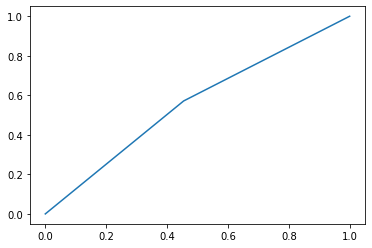

In [115]:
# sklearn에서 ROC 패키지 활용
fpr, tpr, thresholds = roc_curve(test_y,pred_y,pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [116]:
table_logit = logit[-10:]

In [117]:
table_logit['logit'] = pred_y[-10:]

In [118]:
ratio = results.predict_proba(test_x)[-10:] # [-1,1]

In [119]:
table_logit['up_ratio'] = 0.1
for i in range(10):
  table_logit['up_ratio'].iloc[i] = ratio[i][1] 

In [120]:
table_logit.to_csv('samsung_logit_table.csv', index=False)

In [121]:
joblib.dump(results, 'logit_samsung_model.pkl')

['logit_samsung_model.pkl']